In [3]:
import kagglehub

# Import dataset using kagglehub
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/alexdieter/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [4]:
import os

os.listdir(path)

['Test', 'Test.csv', 'Meta', 'Train', 'Meta.csv', 'Train.csv']

In [5]:
import pandas as pd

# 1 Read the CSV files from the kagglehub dataset folder
train_df = pd.read_csv(os.path.join(path, "Train.csv"))
test_df  = pd.read_csv(os.path.join(path, "Test.csv"))
meta_df  = pd.read_csv(os.path.join(path, "Meta.csv"))

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Meta shape:", meta_df.shape)

print("\nTrain columns:", list(train_df.columns))
print("Test columns:", list(test_df.columns))
print("Meta columns:", list(meta_df.columns))

sample_rel_path = train_df.loc[0, "Path"]     
sample_full_path = os.path.join(path, sample_rel_path)

print("\nSample relative path:", sample_rel_path)
print("Sample full path:", sample_full_path)

Train shape: (39209, 8)
Test shape: (12630, 8)
Meta shape: (43, 5)

Train columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Test columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Meta columns: ['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId']

Sample relative path: Train/20/00020_00000_00000.png
Sample full path: /Users/alexdieter/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train/20/00020_00000_00000.png


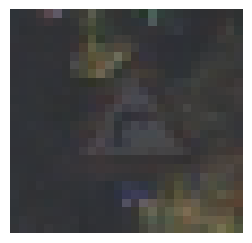

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the sample image
img = Image.open(sample_full_path)

# Display the image
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.show()

In [7]:
import numpy as np

# Resize all images to 32x32 and normalize pixel values to [0, 1]
IMG_SIZE = 32

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    img = img / 255.0
    return img

test_img = preprocess_image(sample_full_path)

print(test_img.shape)
print(test_img.min(), test_img.max())
#0.0 is pure black, 1.0 is pure white

(32, 32, 3)
0.15294117647058825 0.47058823529411764


(32, 32, 3) means a 32×32 RBG (Red, Green Blue) image, and the decimal values mean the pixel intensities have been normalized for neural network training.


In [8]:
from PIL import Image

X = []
y = []

for _, row in train_df.iterrows():
    img_path = os.path.join(path, row["Path"])
    label = row["ClassId"]

    img = Image.open(img_path)
    img = img.resize((32, 32))
    img = np.array(img) / 255.0

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (39209, 32, 32, 3)
y shape: (39209,)


In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 43

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2025,
    stratify=y
)

# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31367, 32, 32, 3)
X_val shape: (7842, 32, 32, 3)
y_train shape: (31367, 43)
y_val shape: (7842, 43)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(43, activation='softmax')
])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.3944 - loss: 2.1290 - val_accuracy: 0.7888 - val_loss: 0.7652
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8078 - loss: 0.6207 - val_accuracy: 0.9379 - val_loss: 0.2358
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9131 - loss: 0.2876 - val_accuracy: 0.9671 - val_loss: 0.1192
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9442 - loss: 0.1854 - val_accuracy: 0.9760 - val_loss: 0.0869
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9601 - loss: 0.1307 - val_accuracy: 0.9860 - val_loss: 0.0585
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9674 - loss: 0.1074 - val_accuracy: 0.9874 - val_loss: 0.0482
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9747 - loss: 0.0834 - val_accuracy: 0.9894 - val_loss: 0.0409
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9764 - loss: 0.0749 - 

The convolutional neural network performed very well on the German Traffic Sign dataset. During training, the model quickly improved and reached high accuracy within the first few epochs. By the end of training, the model achieved about 98.6% accuracy on the training data.

More importantly, the model generalized well to new data. On the validation set, which the model did not see during training, it reached an accuracy of about 99.3%. The validation loss steadily decreased throughout training, showing that the model was learning meaningful patterns instead of overfitting to the training images.

The close match between training and validation performance suggests that the model is stable and reliable. This confirms that the CNN architecture is well-suited for traffic sign classification and is able to correctly identify visual features such as shapes, colors, and symbols across different sign types.

Overall, the results show that the model can accurately classify traffic signs and would work well in a real-world setting where new images are provided as input.

Using the model for a user experience

In [14]:
# Load and preprocess a single image
def predict_traffic_sign(image_path, model):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))
    
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    
    return predicted_class

# Example usage
sample_image_path = sample_full_path  # reuse your earlier sample
predicted_label = predict_traffic_sign(sample_image_path, model)

print("Predicted traffic sign class:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted traffic sign class: 20


In [17]:
CLASS_NAMES = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


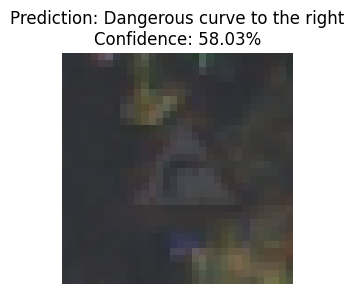

In [18]:
# Build class ID → label mapping
class_names = meta_df.sort_values("ClassId")["Path"].tolist()

def predict_traffic_sign(image_path, model):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))

    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    label = CLASS_NAMES[class_id]

    return label, confidence, img

# Run prediction
label, confidence, img = predict_traffic_sign(sample_full_path, model)

# Display results
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {label}\nConfidence: {confidence:.2%}")
plt.show()

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.98      1.00      0.99        42
                              Speed limit (30km/h)       0.99      0.99      0.99       444
                              Speed limit (50km/h)       1.00      0.99      0.99       450
                              Speed limit (60km/h)       0.98      1.00      0.99       282
                              Speed limit (70km/h)       0.99      1.00      0.99       396
                              Speed limit (80km/h)       0.99      0.98      0.98       372
                       End of speed limit (80km/h)       1.00      0.99      0.99        84
                             Speed limit (100km/h)       0.99      0.97      0.98       288
                             Speed limit (120km/h)       0.97      0.99      0.98       282
                                      

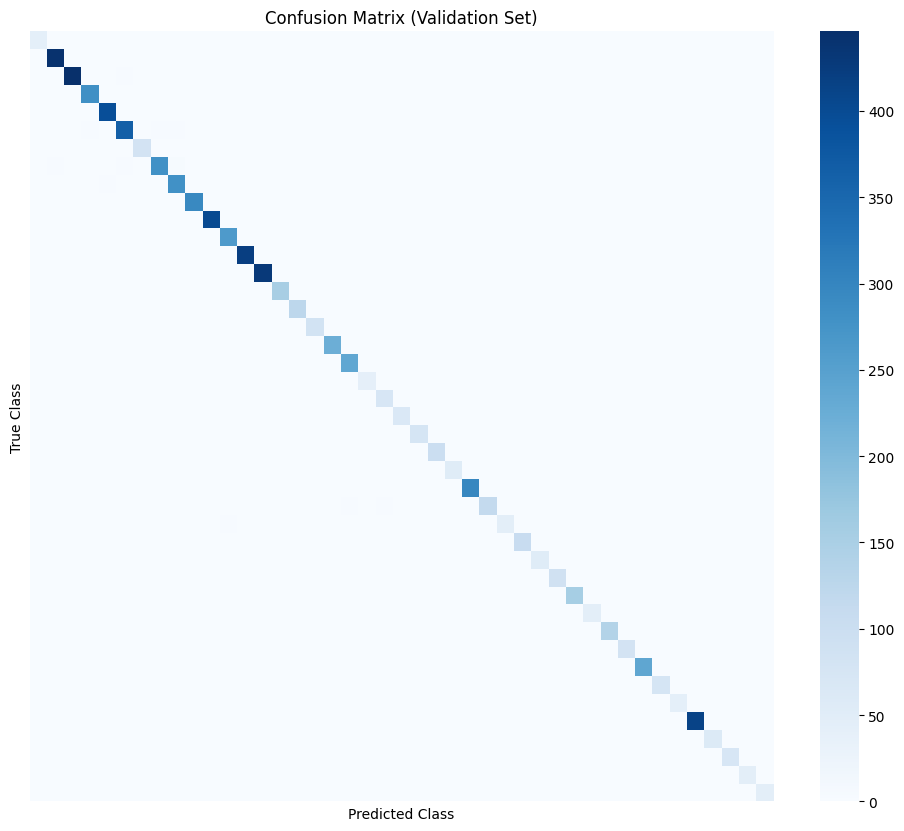

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation set
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Print classification report
print(classification_report(y_val_true, y_val_pred, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Plot confusion matrix (compact view)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

The model performs extremely well on the validation set, achieving about 99% accuracy across all 43 traffic sign classes. The confusion matrix shows a strong diagonal pattern, meaning most predictions are correct. Misclassifications are rare and mostly occur between visually similar signs. Overall, the model generalizes well and demonstrates strong image classification performance.

In [ ]:
def predict_top_k(image_path, model, k=3):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))
    
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    probs = model.predict(img_array)[0]

    top_indices = np.argsort(probs)[::-1][:k]

    results = []
    for idx in top_indices:
        results.append((CLASS_NAMES[idx], probs[idx]))

    return img, results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


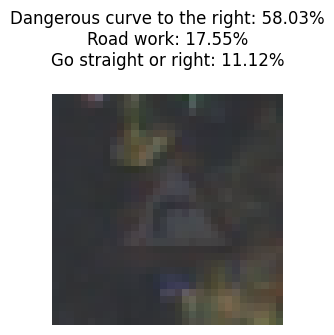

In [ ]:
img, predictions = predict_top_k(sample_full_path, model, k=3)

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")

title_text = ""
for label, conf in predictions:
    title_text += f"{label}: {conf:.2%}\n"

plt.title(title_text)
plt.show()

#### Interactive Prediction Demo

This section randomly selects a traffic sign image from the dataset
and shows the model’s top predicted classes with confidence scores.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


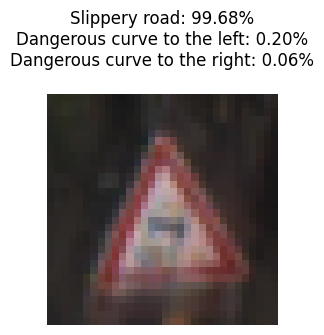

In [ ]:
# This is a demo
import random

random_idx = random.randint(0, len(train_df) - 1)

random_rel_path = train_df.loc[random_idx, "Path"]
random_full_path = os.path.join(path, random_rel_path)

img, predictions = predict_top_k(random_full_path, model, k=3)

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")

title_text = ""
for label, conf in predictions:
    title_text += f"{label}: {conf:.2%}\n"

plt.title(title_text)
plt.show()

In [27]:
# Save model in modern Keras format
model.save("traffic_sign_cnn.keras")

print("Model saved as traffic_sign_cnn.keras")

Model saved as traffic_sign_cnn.keras


In [29]:
from tensorflow.keras.models import load_model

model = load_model("traffic_sign_cnn.keras")
test_img = sample_full_path

img = Image.open(test_img).convert("RGB")
img = img.resize((32, 32))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
print("Predicted class index:", np.argmax(pred))
print("Confidence:", np.max(pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted class index: 20
Confidence: 0.5802931


In [32]:
def predict_traffic_sign(image_path, model, class_names):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)[0]
    class_id = np.argmax(preds)
    confidence = preds[class_id]

    label = CLASS_NAMES[class_id]

    return {
        "label": label,
        "confidence": float(confidence),
        "class_id": int(class_id)
    }
result = predict_traffic_sign(sample_full_path, model, class_names)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


{'label': 'Dangerous curve to the right',
 'confidence': 0.5802931189537048,
 'class_id': 20}

In [34]:
def predict_top_k(image_path, model, class_names, k=3):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))

    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)[0]

    top_indices = np.argsort(preds)[::-1][:k]

    results = []
    for idx in top_indices:
        results.append({
            "class_id": int(idx),
            "label": class_names[idx],
            "confidence": float(preds[idx])
        })

    return results, img

results, img = predict_top_k(sample_full_path, model, CLASS_NAMES)

for r in results:
    print(f"{r['label']}: {r['confidence']:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Dangerous curve to the right: 58.03%
Road work: 17.55%
Go straight or right: 11.12%


In [ ]:
def predict_top_k_clean(image_path, model, class_names, k=3):
    """
    Clean inference function for traffic sign prediction.

    Parameters
    ----------
    image_path : str
        Path to input image
    model : keras.Model
        Trained CNN model
    class_names : list
        List mapping class index -> label
    k : int
        Number of top predictions to return

    Returns
    -------
    dict
        {
          "predictions": [
              {"class_id": int, "label": str, "confidence": float},
              ...
          ]
        }
    """

    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Model prediction
    probs = model.predict(img_array)[0]

    # Top-k indices
    top_indices = np.argsort(probs)[::-1][:k]

    predictions = []
    for idx in top_indices:
        predictions.append({
            "class_id": int(idx),
            "label": class_names[idx],
            "confidence": float(probs[idx])
        })

    return {"predictions": predictions}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Dangerous curve to the right: 58.03%
Road work: 17.55%
Go straight or right: 11.12%
